In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import pydicom as pydicom

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('Data_Entry_2017_v2020.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
984,00005132_000.png,No Finding,0,5132,056Y,F,AP,2500,2048,0.168000,0.168000
915,00004824_003.png,No Finding,3,4824,055Y,F,PA,2992,2991,0.143000,0.143000
5074,00026968_001.png,No Finding,1,26968,020Y,F,PA,2021,2021,0.194311,0.194311


In [4]:
## EDA
# Printing column names for both NIH metadata and sample pixel-level data

print("Columns in Data_Entry_2017_v2020.csv:")
print(all_xray_df.columns.tolist())

print("\nColumns in sample_labels.csv:")
print(sample_df.columns.tolist())

Columns in Data_Entry_2017_v2020.csv:
['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Sex', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]']

Columns in sample_labels.csv:
['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y']


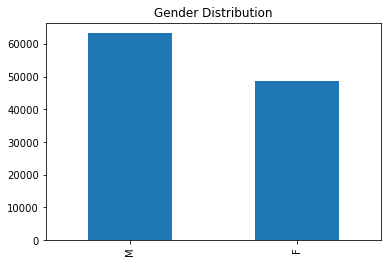

In [5]:
#EDA: Gender Distribution
all_xray_df['Patient Sex'].value_counts().plot(kind='bar', title='Gender Distribution')
plt.show()

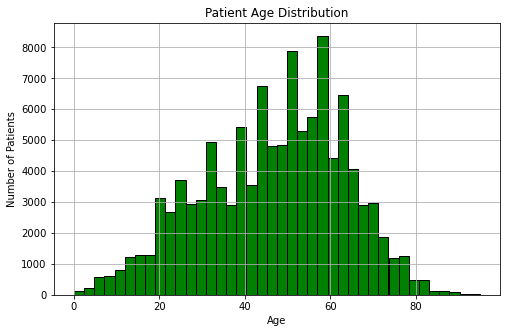

In [6]:
# EDA: Plotting age distribution of patients
plt.figure(figsize=(8, 5))
all_xray_df['Patient Age'].hist(bins=40, color='green', edgecolor='black')
plt.title('Patient Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.show()


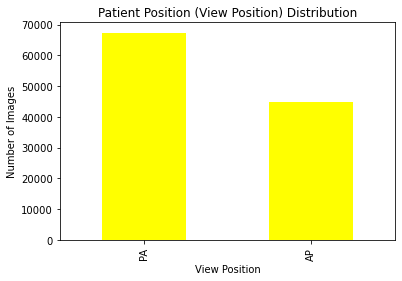

In [7]:
# EDA: Plotting the distribution of "View Position" (Patient Position) with yellow bars
all_xray_df['View Position'].value_counts().plot(
    kind='bar', 
    color='yellow', 
    title='Patient Position (View Position) Distribution'
)
plt.xlabel('View Position')
plt.ylabel('Number of Images')
plt.show()


Number of pneumonia cases: 1431
Number of non-pneumonia cases: 110689


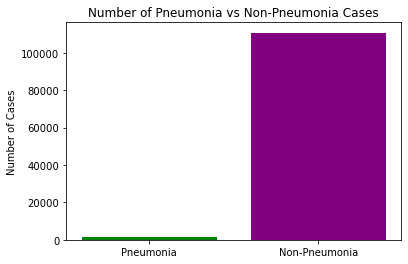

In [8]:
# EDA: Number of pneumonia and non-pneumonia cases

# Create a boolean mask for pneumonia
is_pneumonia = all_xray_df['Finding Labels'].str.contains('Pneumonia', case=False)

num_pneumonia = is_pneumonia.sum()
num_non_pneumonia = (~is_pneumonia).sum()

print(f"Number of pneumonia cases: {num_pneumonia}")
print(f"Number of non-pneumonia cases: {num_non_pneumonia}")

# Plotting
plt.bar(['Pneumonia', 'Non-Pneumonia'], [num_pneumonia, num_non_pneumonia], color=['green', 'purple'])
plt.title('Number of Pneumonia vs Non-Pneumonia Cases')
plt.ylabel('Number of Cases')
plt.show()

#Add a count for each column as a label
def add_count_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom')

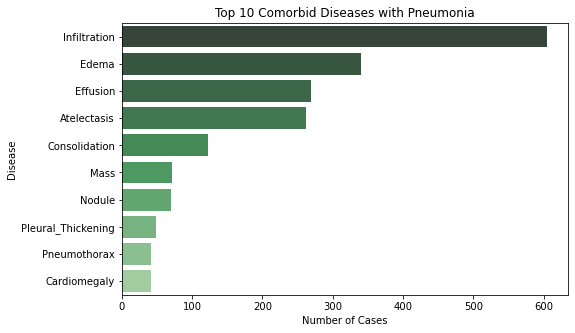

In [9]:
from collections import Counter

# Filter for pneumonia cases
pneumonia_cases = all_xray_df[is_pneumonia]

# Split 'Finding Labels' and count comorbidities (excluding 'Pneumonia')
comorbidities = []
for labels in pneumonia_cases['Finding Labels']:
    diseases = [d.strip() for d in labels.split('|') if d.strip().lower() != 'pneumonia']
    comorbidities.extend(diseases)

comorbidity_counts = Counter(comorbidities)
top_comorbid = comorbidity_counts.most_common(10)

# Convert to DataFrame for plotting
comorbidity_df = pd.DataFrame(top_comorbid, columns=['Disease', 'Count'])

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=comorbidity_df, x='Count', y='Disease', hue='Disease', dodge=False, palette='Greens_d')
plt.title('Top 10 Comorbid Diseases with Pneumonia')
plt.legend([],[], frameon=False)  # Hide legend since hue is just for color
plt.xlabel('Number of Cases')
plt.ylabel('Disease')
plt.show()

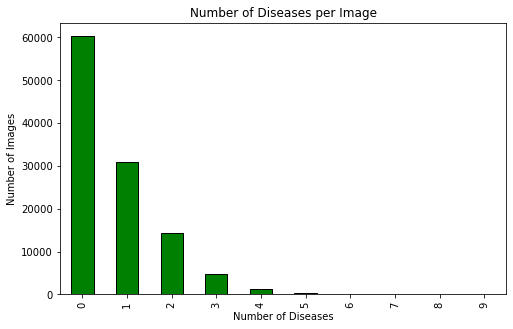

In [10]:
#EDA: Plotting the number of diseases per patient
# Count number of diseases per image (excluding 'No Finding')
all_xray_df['Num Diseases'] = all_xray_df['Finding Labels'].apply(
    lambda x: 0 if x == 'No Finding' else len(x.split('|'))
)

plt.figure(figsize=(8,5))
all_xray_df['Num Diseases'].value_counts().sort_index().plot(
    kind='bar', color='green', edgecolor='black'
)
plt.title('Number of Diseases per Image')
plt.xlabel('Number of Diseases')
plt.ylabel('Number of Images')
plt.show()

Scans found: 112120 , Total Headers 112120


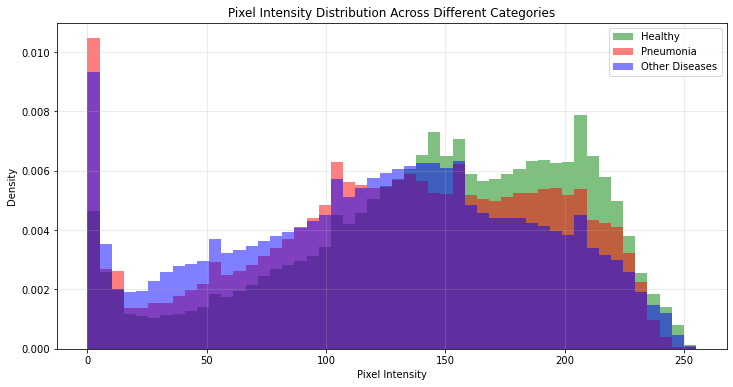


Healthy Statistics:
Mean pixel intensity: 145.04
Std pixel intensity: 59.96
Min pixel intensity: 0.00
Max pixel intensity: 255.00

Pneumonia Statistics:
Mean pixel intensity: 128.79
Std pixel intensity: 63.80
Min pixel intensity: 0.00
Max pixel intensity: 255.00

Other Diseases Statistics:
Mean pixel intensity: 122.21
Std pixel intensity: 63.73
Min pixel intensity: 0.00
Max pixel intensity: 255.00


In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import pandas as pd

# Load the NIH data and image paths
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df = all_xray_df.dropna(subset=['path'])  # Drop rows without image path

# Get paths for different categories
healthy_paths = all_xray_df[all_xray_df['Finding Labels'] == 'No Finding']['path'].values
pneumonia_paths = all_xray_df[all_xray_df['Finding Labels'].str.contains('Pneumonia')]['path'].values
other_disease_paths = all_xray_df[
    (all_xray_df['Finding Labels'] != 'No Finding') & 
    (~all_xray_df['Finding Labels'].str.contains('Pneumonia'))
]['path'].values

# Sample images (using fewer samples for faster processing)
healthy_samples = healthy_paths[:50]
pneumonia_samples = pneumonia_paths[:50]
other_disease_samples = other_disease_paths[:50]

def get_pixel_values(image_paths):
    pixels = []
    for path in image_paths:
        try:
            # Using PIL instead of cv2
            img = np.array(Image.open(path).convert('L'))  # 'L' mode for grayscale
            pixels.append(img.flatten())
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue
    return np.concatenate(pixels) if pixels else np.array([])

# Get pixel values for each category
healthy_pixels = get_pixel_values(healthy_samples)
pneumonia_pixels = get_pixel_values(pneumonia_samples)
other_disease_pixels = get_pixel_values(other_disease_samples)

# Create visualization
plt.figure(figsize=(12, 6))

if healthy_pixels.size > 0:
    plt.hist(healthy_pixels, bins=50, alpha=0.5, 
             label='Healthy', color='green', density=True)
if pneumonia_pixels.size > 0:
    plt.hist(pneumonia_pixels, bins=50, alpha=0.5, 
             label='Pneumonia', color='red', density=True)
if other_disease_pixels.size > 0:
    plt.hist(other_disease_pixels, bins=50, alpha=0.5, 
             label='Other Diseases', color='blue', density=True)

plt.title('Pixel Intensity Distribution Across Different Categories')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
for name, pixels in [("Healthy", healthy_pixels), 
                    ("Pneumonia", pneumonia_pixels), 
                    ("Other Diseases", other_disease_pixels)]:
    if pixels.size > 0:
        print(f"\n{name} Statistics:")
        print(f"Mean pixel intensity: {pixels.mean():.2f}")
        print(f"Std pixel intensity: {pixels.std():.2f}")
        print(f"Min pixel intensity: {pixels.min():.2f}")
        print(f"Max pixel intensity: {pixels.max():.2f}")